In [74]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import f1_score,accuracy_score

from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import mean_squared_error,confusion_matrix


import keras
import keras_tuner
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization


In [75]:
pd.set_option("display.width",500)
pd.set_option("display.max_columns",None)

In [76]:
diabetes = pd.read_csv("/kaggle/input/pima-indians-diabetes-database/diabetes.csv")
df=diabetes.copy()

# EDA

In [77]:
def summary_data(dataframe,sample=5):
    func = {"Info":".info()",
           "Shape":".shape",
           "Ndim":".ndim",
           "Head":".head(sample)",
           "Tail":".tail(sample)",
           "NA":".isnull().sum()",
           "Describe":".describe().T"}
    
    for k,v in func.items():
        print("\n###################################### {} ######################################\n".format(k))
        display(eval(eval("'dataframe'+v")))

In [78]:
summary_data(df)


###################################### Info ######################################

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


None


###################################### Shape ######################################



(768, 9)


###################################### Ndim ######################################



2


###################################### Head ######################################



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1



###################################### Tail ######################################



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0



###################################### NA ######################################



Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


###################################### Describe ######################################



,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [79]:
df["Outcome"].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [80]:
num_cols = [col for col in df.columns if df[col].nunique() > 10]
cat_cols = [col for col in df.columns if df[col].nunique() <= 10]

In [81]:
num_cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [82]:
cat_cols

['Outcome']

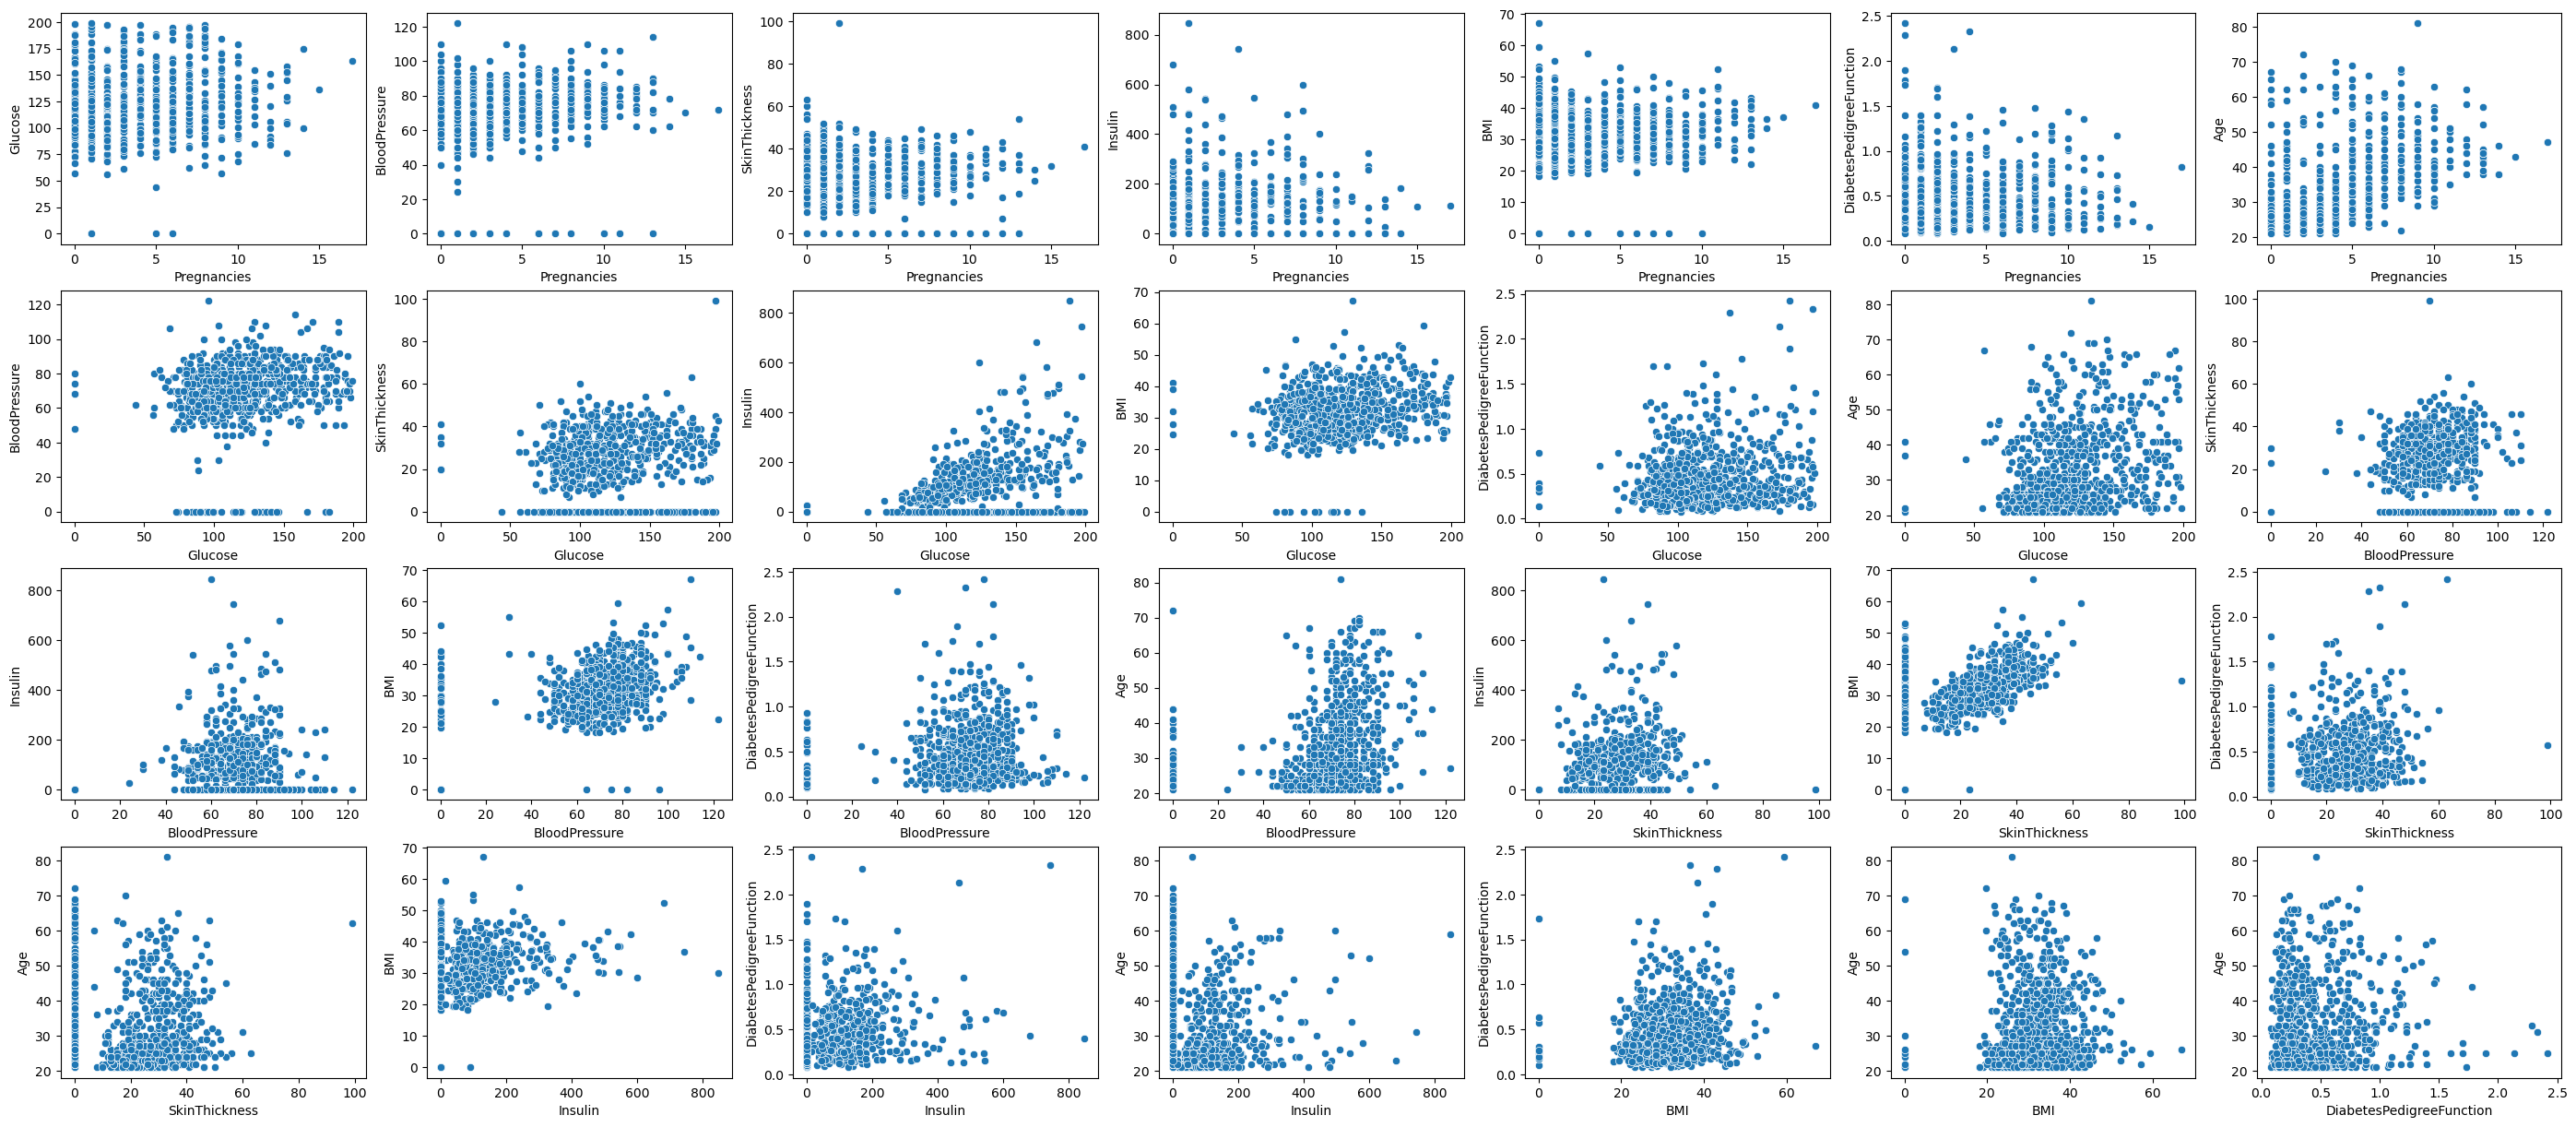

In [83]:
plt.figure(figsize=(35,15))
sub = 1
for index,col1 in enumerate(num_cols):
    for num in range(index+1,len(num_cols)):
        plt.subplot(4,7,sub)
        sns.scatterplot(data=df,x=col1,y=num_cols[num])
        sub += 1

<Axes: >

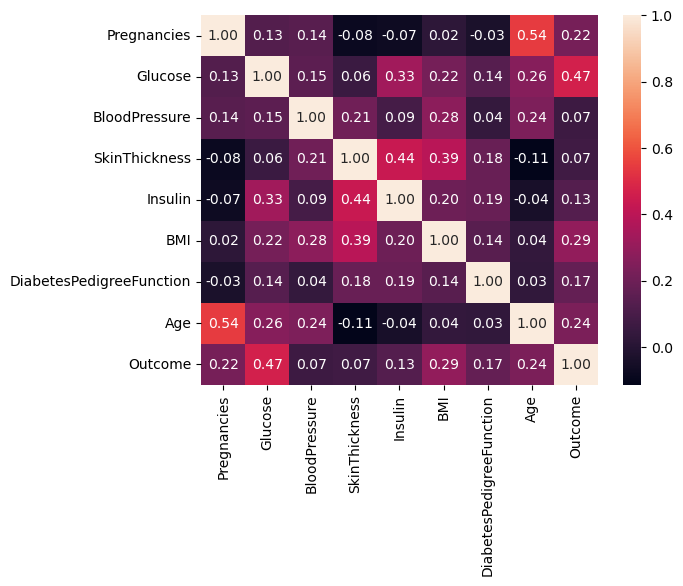

In [84]:
sns.heatmap(df.corr(),fmt=".2f",annot=True)

Text(0.5, 1.0, 'Outcome')

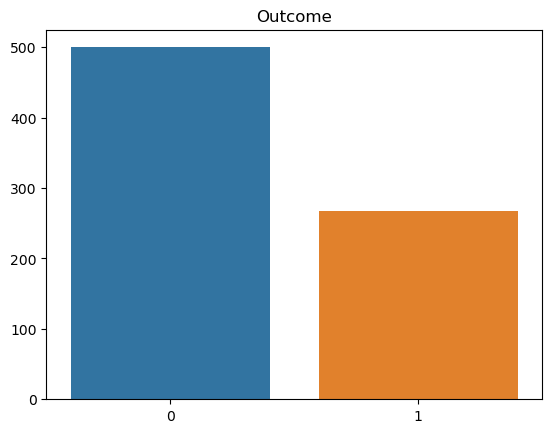

In [85]:
sns.barplot(x=df["Outcome"].value_counts().index.values,y=df["Outcome"].value_counts().values)
plt.title("Outcome")

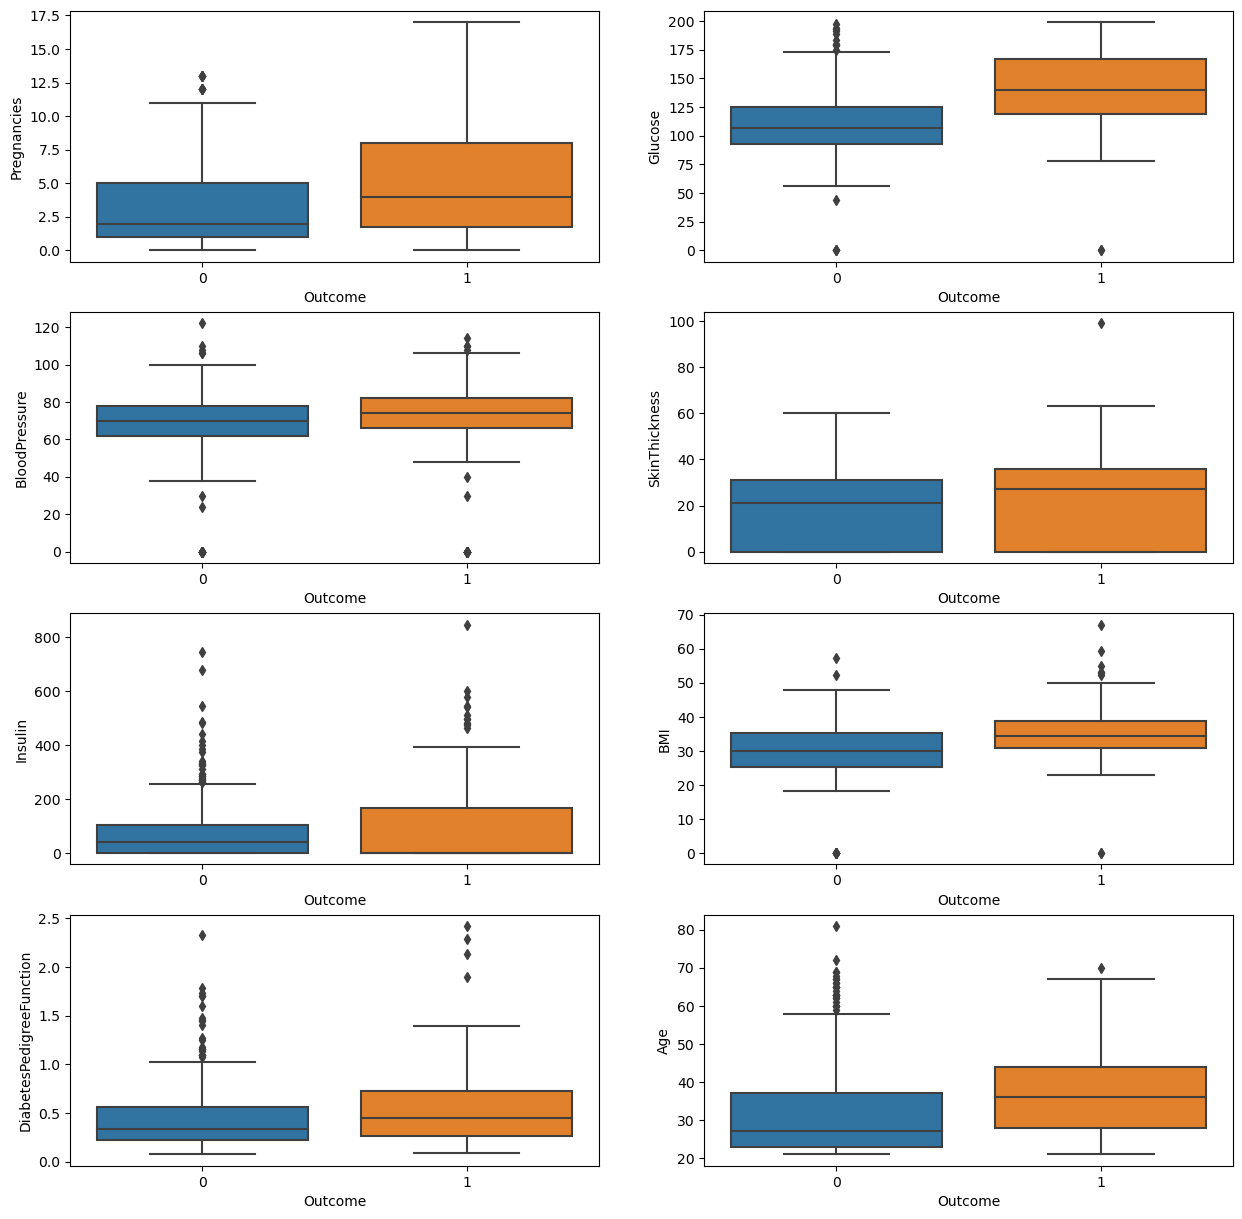

In [86]:
plt.figure(figsize=(15,15))
for i,col in enumerate(num_cols):
    plt.subplot(4,2,i+1)
    sns.boxplot(data=df.iloc[:,:],x="Outcome",y=col)

# Data Preprocessing

In [87]:
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [88]:
for i in df.columns:
    df[i] = df[i].fillna(df.groupby("Outcome")[i].transform("mean"))

imputer = KNNImputer(n_neighbors=20)
df = pd.DataFrame(imputer.fit_transform(df),columns=df.columns)

imp_mean = IterativeImputer(random_state=42,skip_complete=True,max_iter=500,sample_posterior=True,verbose=1)
imp_mean.fit(df)
df = pd.DataFrame(imp_mean.transform(df),columns=df.columns)

In [89]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [90]:
x = df[num_cols]
y = df[cat_cols]

In [91]:
lof = LocalOutlierFactor(n_neighbors=20)
lof.fit_predict(x)

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [92]:
pd.Series(lof.negative_outlier_factor_).describe()

count    768.000000
mean      -1.131286
std        0.187433
min       -2.802535
25%       -1.190161
50%       -1.078512
75%       -1.014414
max       -0.946256
dtype: float64

In [93]:
pd.set_option("display.max_rows",20)

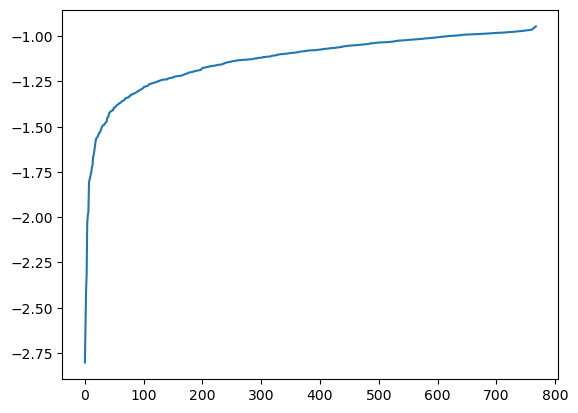

In [94]:
plt.plot(pd.Series(lof.negative_outlier_factor_).sort_values().reset_index(drop=True))

In [95]:
outlier_threshold_low = pd.Series(lof.negative_outlier_factor_).sort_values().reset_index(drop=True)[75]
outlier_threshold_low

-1.3345267414156161

outlier_threshold_high = pd.Series(lof.negative_outlier_factor_).sort_values().reset_index(drop=True)[799]
outlier_threshold_high

In [96]:
yeni_df = df[(pd.Series(lof.negative_outlier_factor_) > outlier_threshold_low)]

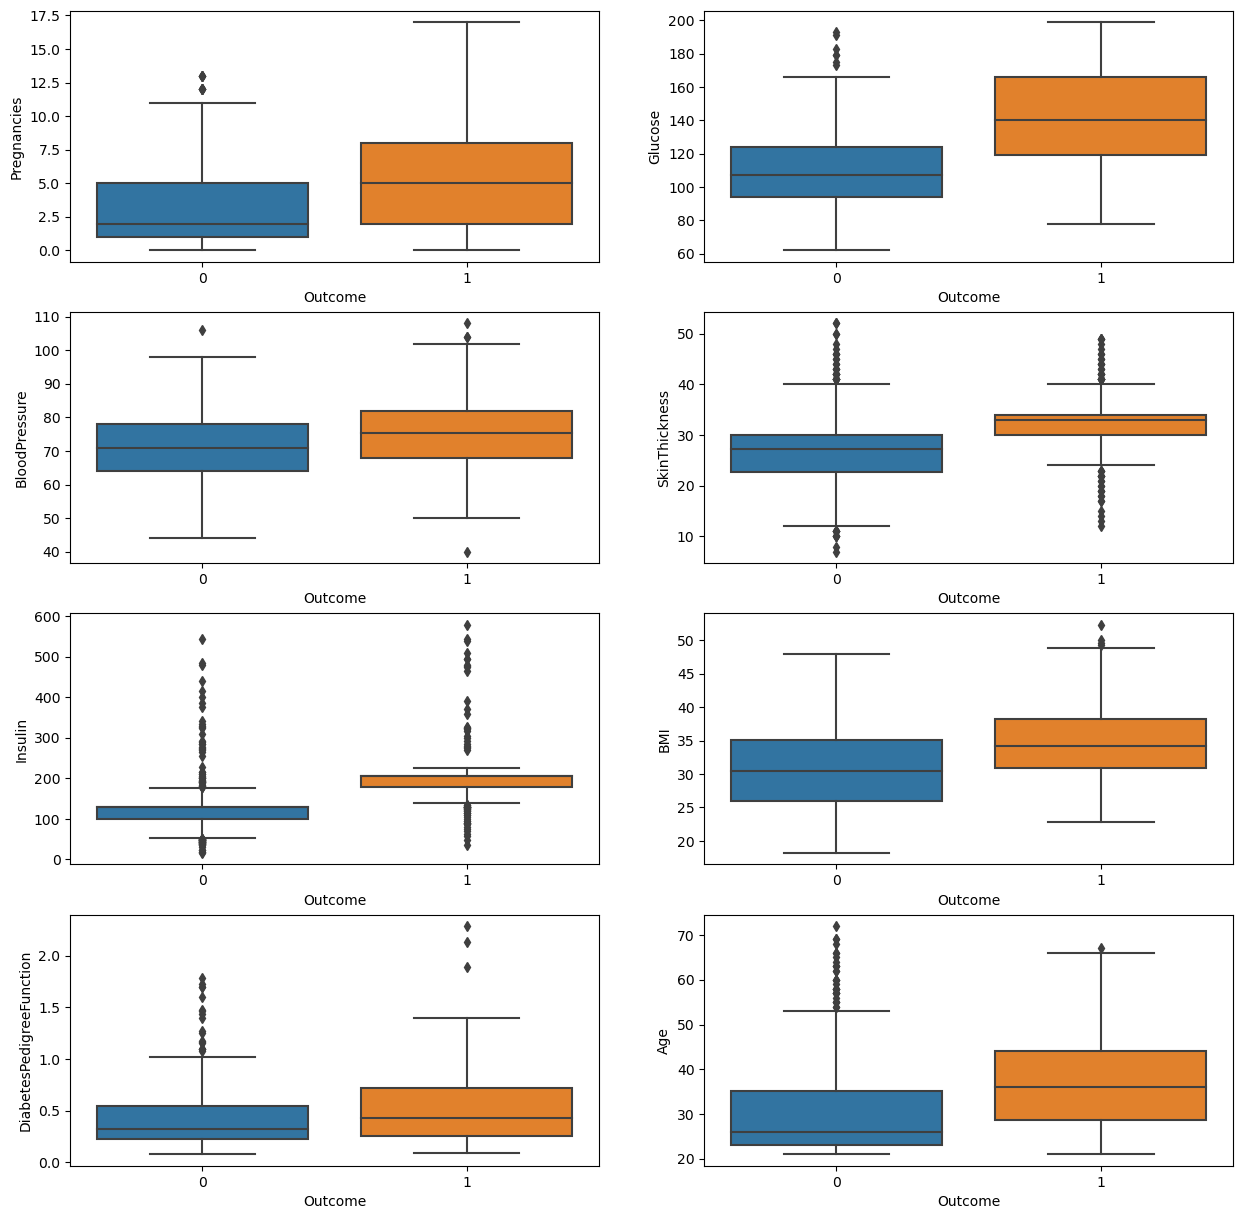

In [97]:
plt.figure(figsize=(15,15))
for i,col in enumerate(num_cols):
    plt.subplot(4,2,i+1)
    sns.boxplot(data=yeni_df.iloc[:,:],x="Outcome",y=col)

# Deep Learning

In [98]:
X = df[num_cols]
Y = df[cat_cols]

In [99]:
X_new = yeni_df[num_cols]
Y_new = yeni_df[cat_cols]

In [100]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=42,shuffle=True)

In [101]:
x_train_new,x_test_new,y_train_new,y_test_new = train_test_split(X_new,Y_new,test_size=0.3,random_state=42,shuffle=True)

In [102]:
clf = Sequential()

In [103]:
clf.add(Dense(units=8,activation="relu",input_dim=len(num_cols)))
clf.add(Dropout(rate=0.1))
clf.add(Dense(units=4,activation="relu"))
clf.add(Dropout(rate=0.1))
clf.add(Dense(units=2,activation="relu"))
clf.add(Dropout(rate=0.1))
clf.add(Dense(units=1,activation="sigmoid"))
clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [104]:
dtype=[]
auc=[]
acc=[]
mse=[]
f1=[]

### Pure Data

In [105]:
sc = StandardScaler()
sc.fit(x_train)

X_train = sc.transform(x_train)
X_test = sc.transform(x_test)

In [106]:
pure=clf.fit(X_train, y_train, batch_size=50,epochs=500,verbose=0)

In [107]:
y_pred = clf.predict(X_test)

8/8 [==============================] - 0s 2ms/step


In [108]:
Y_pred = (y_pred > 0.5)

In [109]:
dtype.append("Pure")
acc.append(accuracy_score(y_test,Y_pred))
mse.append(mean_squared_error(y_test, Y_pred, squared=False))
f1.append(f1_score(y_test,Y_pred))

### Without outliers

In [110]:
sc.fit(x_train_new)

X_train_new = sc.transform(x_train_new)
X_test_new = sc.transform(x_test_new)

In [111]:
out = clf.fit(X_train_new, y_train_new, batch_size=50,epochs=500,verbose=0)

In [112]:
y_pred_new = clf.predict(X_test_new)

7/7 [==============================] - 0s 2ms/step


In [113]:
Y_pred_new = (y_pred_new > 0.5)

In [114]:
dtype.append("Without Outliers")
acc.append(accuracy_score(y_test_new,Y_pred_new))
mse.append(mean_squared_error(y_test_new, Y_pred_new, squared=False))
f1.append(f1_score(y_test_new, Y_pred_new))

### Balanced Data

In [115]:
ros = RandomOverSampler(random_state=42,)
x_train_resampled, y_train_resampled = ros.fit_resample(x_train_new, y_train_new)

In [116]:
sc.fit(x_train_resampled)

X_train_resampled = sc.transform(x_train_resampled)
X_test_resampled = sc.transform(x_test_new)

In [117]:
y_train_resampled.value_counts()

Outcome
0          317
1          317
dtype: int64

In [118]:
balanced = clf.fit(X_train_resampled, y_train_resampled, batch_size=50,epochs=500,verbose=0)

In [119]:
y_pred_resampled = clf.predict(X_test_resampled)

7/7 [==============================] - 0s 2ms/step


In [120]:
Y_pred_resampled = (y_pred_resampled > 0.5)

In [121]:
dtype.append("Balanced")
acc.append(accuracy_score(y_test_new,Y_pred_resampled))
mse.append(mean_squared_error(y_test_new, Y_pred_resampled, squared=False))
f1.append(f1_score(y_test_new, Y_pred_resampled))

## Evaluation

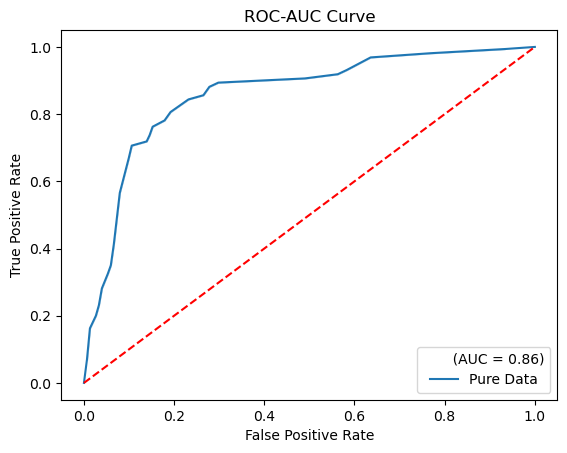

In [122]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
auc.append(roc_auc)
sns.lineplot(x=fpr,y=tpr,errorbar =('se',0.01))
plt.plot([0, 1], [0, 1], 'r--')
plt.legend(title="       (AUC = {:.2f})".format(roc_auc),loc="lower right",labels=["Pure Data"])
plt.title("ROC-AUC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

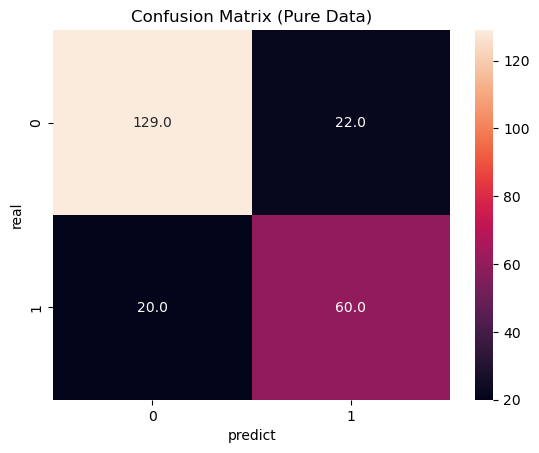

In [123]:
cm = confusion_matrix(y_test,Y_pred)
sns.heatmap(cm,annot=True,fmt=".1f")
plt.title("Confusion Matrix (Pure Data)")
plt.xlabel("predict")
plt.ylabel("real");

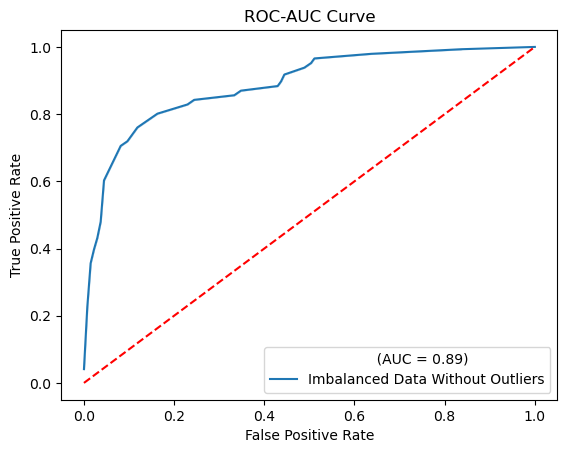

In [124]:
fpr, tpr, thresholds = metrics.roc_curve(y_test_new, y_pred_new)
roc_auc = metrics.auc(fpr, tpr)
auc.append(roc_auc)
sns.lineplot(x=fpr,y=tpr,errorbar =('se',0.01))
plt.plot([0, 1], [0, 1], 'r--')
plt.legend(title="       (AUC = {:.2f})".format(roc_auc),loc="lower right",labels=["Imbalanced Data Without Outliers"])
plt.title("ROC-AUC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

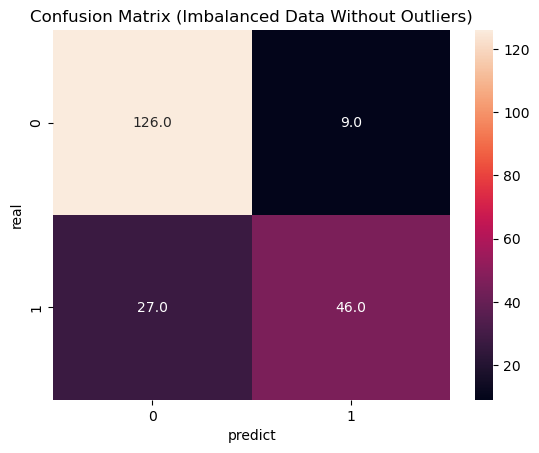

In [125]:
cm = confusion_matrix(y_test_new,Y_pred_new)
sns.heatmap(cm,annot=True,fmt=".1f")
plt.title("Confusion Matrix (Imbalanced Data Without Outliers)")
plt.xlabel("predict")
plt.ylabel("real");

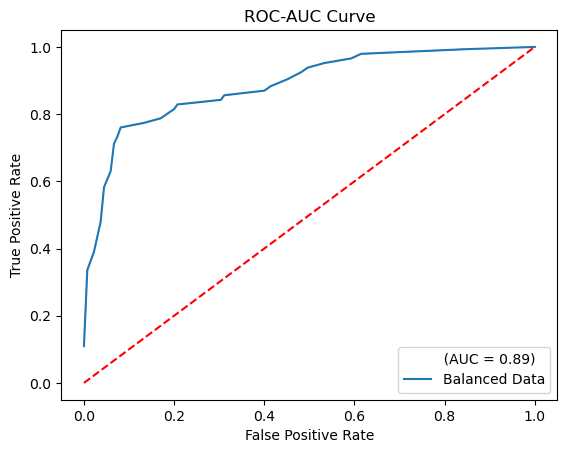

In [126]:
fpr, tpr, thresholds = metrics.roc_curve(y_test_new, y_pred_resampled)
roc_auc = metrics.auc(fpr, tpr)
auc.append(roc_auc)
sns.lineplot(x=fpr,y=tpr,errorbar =('se',0.01))
plt.plot([0, 1], [0, 1], 'r--')
plt.legend(title="       (AUC = {:.2f})".format(roc_auc),loc="lower right",labels=["Balanced Data"])
plt.title("ROC-AUC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

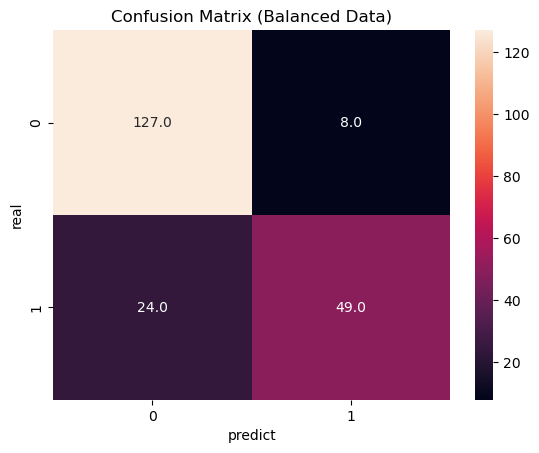

In [127]:
cm = confusion_matrix(y_test_new,Y_pred_resampled)
sns.heatmap(cm,annot=True,fmt=".1f")
plt.title("Confusion Matrix (Balanced Data)")
plt.xlabel("predict")
plt.ylabel("real");

## Optimization

In [128]:
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Dense(units=hp.Int(f'units_{1}',min_value=16,max_value=64,step=4),activation=hp.Choice(f'activation_{1}',['relu','tanh', 'selu'])))
    model.add(keras.layers.Dropout(hp.Choice(f'rate_{1}',[0.0,0.05,0.1,0.2])))
    model.add(keras.layers.Dense(units=hp.Int(f'units_{2}',min_value=8,max_value=32,step=4),activation=hp.Choice(f'activation_{2}',['relu','tanh', 'selu'])))
    model.add(keras.layers.Dropout(hp.Choice(f'rate_{2}',[0.0,0.05,0.1,0.2])))
    model.add(keras.layers.Dense(units=hp.Int(f'units_{3}',min_value=2,max_value=16,step=2),activation=hp.Choice(f'activation_{3}',['relu','tanh', 'selu'])))
    model.add(keras.layers.Dropout(hp.Choice(f'rate_{3}',[0.0,0.05,0.1,0.2])))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    optimizer = hp.Choice("optimizer", ["adam", "sgd",'RMSprop'])
    model.compile(optimizer,loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [129]:
build_model(keras_tuner.HyperParameters())

In [130]:
tuner = keras_tuner.RandomSearch(
    build_model,
    max_trials=20,
    objective='val_loss',
    overwrite=True)

In [131]:
tuner.search_space_summary()

Search space summary
Default search space size: 10
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 4, 'sampling': 'linear'}
activation_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'selu'], 'ordered': False}
rate_1 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.05, 0.1, 0.2], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 32, 'step': 4, 'sampling': 'linear'}
activation_2 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'selu'], 'ordered': False}
rate_2 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.05, 0.1, 0.2], 'ordered': True}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 16, 'step': 2, 'sampling': 'linear'}
activation_3 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'selu'], 'ordered': False}
rate_3 (Choice)
{'default': 0.0, 'conditions': [], 'valu

In [132]:
x_train_opt,x_val_opt,y_train_opt,y_val_opt = train_test_split(X_train_resampled,y_train_resampled,test_size=0.2,random_state=42,shuffle=True)

In [133]:
x_train_opt.shape

(507, 8)

In [134]:
tuner.search(x_train_opt, y_train_opt, epochs=50,validation_data=(x_val_opt,y_val_opt))

Trial 20 Complete [00h 00m 06s]
val_loss: 0.3281346559524536

Best val_loss So Far: 0.29516980051994324
Total elapsed time: 00h 02m 06s


In [135]:
best_model=tuner.get_best_models()[0]

In [136]:
best_model.build(input_shape=(1,8))

In [137]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 16 summary
Hyperparameters:
units_1: 32
activation_1: selu
rate_1: 0.0
units_2: 32
activation_2: selu
rate_2: 0.0
units_3: 6
activation_3: relu
rate_3: 0.1
optimizer: RMSprop
Score: 0.29516980051994324

Trial 09 summary
Hyperparameters:
units_1: 56
activation_1: selu
rate_1: 0.1
units_2: 16
activation_2: selu
rate_2: 0.0
units_3: 4
activation_3: tanh
rate_3: 0.2
optimizer: RMSprop
Score: 0.2971900701522827

Trial 08 summary
Hyperparameters:
units_1: 64
activation_1: relu
rate_1: 0.05
units_2: 28
activation_2: tanh
rate_2: 0.0
units_3: 10
activation_3: relu
rate_3: 0.0
optimizer: adam
Score: 0.29817667603492737

Trial 06 summary
Hyperparameters:
units_1: 32
activation_1: tanh
rate_1: 0.0
units_2: 16
activation_2: selu
rate_2: 0.1
units_3: 16
activation_3: relu
rate_3: 0.05
optimizer: RMSprop
Score: 0.30493438243865967

Trial 05 summary
Hyperparameters:
units_1: 36
acti

In [138]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 32)                   288       
                                                                 
 dropout (Dropout)           (1, 32)                   0         
                                                                 
 dense_1 (Dense)             (1, 32)                   1056      
                                                                 
 dropout_1 (Dropout)         (1, 32)                   0         
                                                                 
 dense_2 (Dense)             (1, 6)                    198       
                                                                 
 dropout_2 (Dropout)         (1, 6)                    0         
                                                                 
 dense_3 (Dense)             (1, 1)                    7

In [139]:
y_pred_optimized = best_model.predict(X_test_resampled)
Y_pred_optimized = y_pred_optimized > 0.5

7/7 [==============================] - 0s 2ms/step


## Evaluation

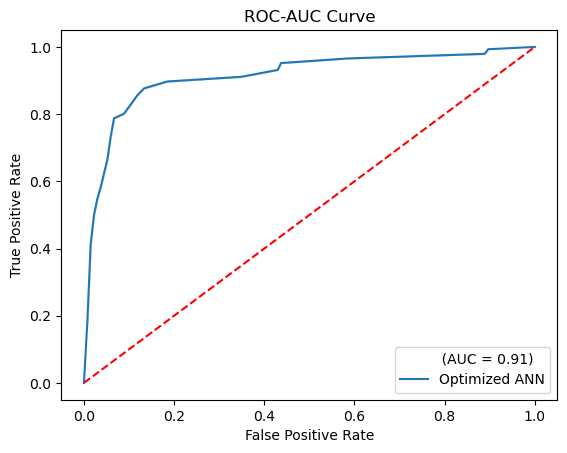

In [140]:
fpr, tpr, thresholds = metrics.roc_curve(y_test_new, y_pred_optimized)
roc_auc = metrics.auc(fpr, tpr)
auc.append(roc_auc)
sns.lineplot(x=fpr,y=tpr,errorbar =('se',0.01))
plt.plot([0, 1], [0, 1], 'r--')
plt.legend(title="       (AUC = {:.2f})".format(roc_auc),loc="lower right",labels=["Optimized ANN"])
plt.title("ROC-AUC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

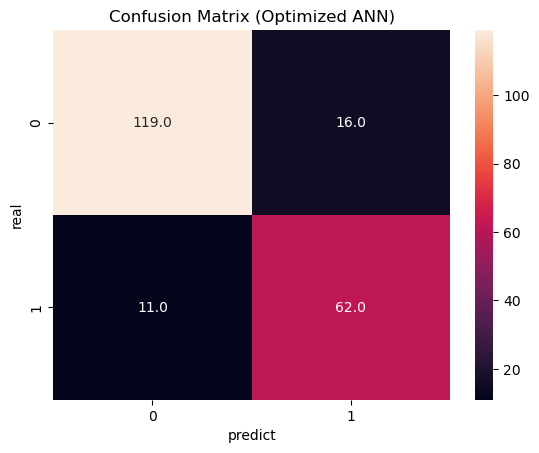

In [141]:
cm = confusion_matrix(y_test_new,Y_pred_optimized)
sns.heatmap(cm,annot=True,fmt=".1f")
plt.title("Confusion Matrix (Optimized ANN)")
plt.xlabel("predict")
plt.ylabel("real");

In [142]:
dtype.append("Optimized")
acc.append(accuracy_score(y_test_new,Y_pred_optimized))
mse.append(mean_squared_error(y_test_new,Y_pred_optimized,squared=False))
f1.append(f1_score(y_test_new,Y_pred_optimized))

In [143]:
evaluation_data=pd.DataFrame({"Dtype":dtype,"Accuracy":acc,"Mean Squared Error":mse,"F1 Score":f1,"AUC":auc})
evaluation_data

,Dtype,Accuracy,Mean Squared Error,F1 Score,AUC
0,Pure,0.818182,0.426401,0.740741,0.860017
1,Without Outliers,0.826923,0.416025,0.718750,0.887722
2,Balanced,0.846154,0.392232,0.753846,0.887215
3,Optimized,0.870192,0.360288,0.821192,0.913039


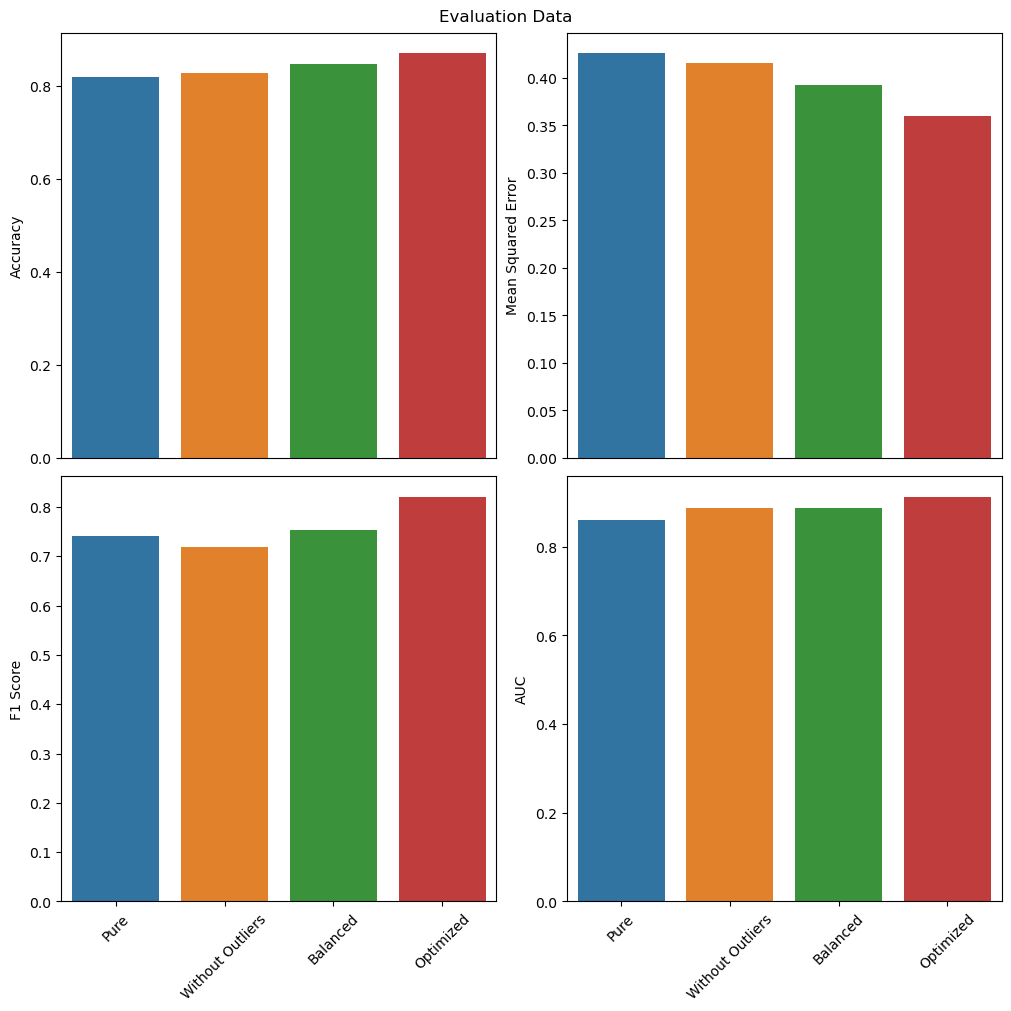

In [144]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, constrained_layout=True,figsize=(10,10))

fig.suptitle("Evaluation Data")
sns.barplot(x="Dtype",y="Accuracy",data=evaluation_data,ax=ax1)
ax1.set_xticks([])
ax1.set_xlabel("")

sns.barplot(x="Dtype",y="Mean Squared Error",data=evaluation_data,ax=ax2)
ax2.set_xticks([])
ax2.set_xlabel("")

sns.barplot(x="Dtype",y="F1 Score",data=evaluation_data,ax=ax3)
ax3.tick_params(axis='x', labelrotation=45)
ax3.set_xlabel("")

sns.barplot(x="Dtype",y="AUC",data=evaluation_data,ax=ax4)
#ax4.set_xticks([])
ax4.tick_params(axis='x', labelrotation=45)
ax4.set_xlabel("")

plt.show()